# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 16            
model_seed = 6           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3065 | Test Loss 2.3107 | accs Train 0.0833 Test 0.0603


Epoch 100/3000: Train Loss 0.0069 | Test Loss 1.2799 | accs Train 1.0000 Test 0.6444


Epoch 200/3000: Train Loss 0.0029 | Test Loss 1.3510 | accs Train 1.0000 Test 0.6440


Epoch 300/3000: Train Loss 0.0018 | Test Loss 1.3933 | accs Train 1.0000 Test 0.6444


Epoch 400/3000: Train Loss 0.0013 | Test Loss 1.4234 | accs Train 1.0000 Test 0.6441


Epoch 500/3000: Train Loss 0.0010 | Test Loss 1.4467 | accs Train 1.0000 Test 0.6439


Epoch 600/3000: Train Loss 0.0008 | Test Loss 1.4656 | accs Train 1.0000 Test 0.6437


Epoch 700/3000: Train Loss 0.0007 | Test Loss 1.4815 | accs Train 1.0000 Test 0.6434


Epoch 800/3000: Train Loss 0.0006 | Test Loss 1.4951 | accs Train 1.0000 Test 0.6436


Epoch 900/3000: Train Loss 0.0005 | Test Loss 1.5069 | accs Train 1.0000 Test 0.6437


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.5174 | accs Train 1.0000 Test 0.6438


Epoch 1100/3000: Train Loss 0.0004 | Test Loss 1.5267 | accs Train 1.0000 Test 0.6437


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.5350 | accs Train 1.0000 Test 0.6435


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.5424 | accs Train 1.0000 Test 0.6429


Epoch 1400/3000: Train Loss 0.0003 | Test Loss 1.5491 | accs Train 1.0000 Test 0.6427


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.5553 | accs Train 1.0000 Test 0.6427


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.5609 | accs Train 1.0000 Test 0.6427


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.5661 | accs Train 1.0000 Test 0.6427


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.5709 | accs Train 1.0000 Test 0.6425


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.5753 | accs Train 1.0000 Test 0.6429


Epoch 2000/3000: Train Loss 0.0002 | Test Loss 1.5794 | accs Train 1.0000 Test 0.6429


Epoch 2100/3000: Train Loss 0.0002 | Test Loss 1.5832 | accs Train 1.0000 Test 0.6431


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.5867 | accs Train 1.0000 Test 0.6431


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.5899 | accs Train 1.0000 Test 0.6430


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.5929 | accs Train 1.0000 Test 0.6430


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.5957 | accs Train 1.0000 Test 0.6430


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.5983 | accs Train 1.0000 Test 0.6426


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.6008 | accs Train 1.0000 Test 0.6424


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.6031 | accs Train 1.0000 Test 0.6423


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.6053 | accs Train 1.0000 Test 0.6422


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.6073 | accs Train 1.0000 Test 0.6423
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3077 | Test Loss 2.3107 | accs Train 0.0650 Test 0.0603


Epoch 100/3000: Train Loss 0.1255 | Test Loss 0.4326 | accs Train 0.9800 Test 0.8717


Epoch 200/3000: Train Loss 0.0246 | Test Loss 0.4645 | accs Train 1.0000 Test 0.8740


Epoch 300/3000: Train Loss 0.0111 | Test Loss 0.4951 | accs Train 1.0000 Test 0.8755


Epoch 400/3000: Train Loss 0.0068 | Test Loss 0.5169 | accs Train 1.0000 Test 0.8752


Epoch 500/3000: Train Loss 0.0048 | Test Loss 0.5334 | accs Train 1.0000 Test 0.8759


Epoch 600/3000: Train Loss 0.0037 | Test Loss 0.5467 | accs Train 1.0000 Test 0.8764


Epoch 700/3000: Train Loss 0.0029 | Test Loss 0.5576 | accs Train 1.0000 Test 0.8763


Epoch 800/3000: Train Loss 0.0024 | Test Loss 0.5669 | accs Train 1.0000 Test 0.8765


Epoch 900/3000: Train Loss 0.0021 | Test Loss 0.5749 | accs Train 1.0000 Test 0.8766


Epoch 1000/3000: Train Loss 0.0018 | Test Loss 0.5819 | accs Train 1.0000 Test 0.8766


Epoch 1100/3000: Train Loss 0.0016 | Test Loss 0.5880 | accs Train 1.0000 Test 0.8763


Epoch 1200/3000: Train Loss 0.0014 | Test Loss 0.5936 | accs Train 1.0000 Test 0.8764


Epoch 1300/3000: Train Loss 0.0013 | Test Loss 0.5986 | accs Train 1.0000 Test 0.8766


Epoch 1400/3000: Train Loss 0.0012 | Test Loss 0.6031 | accs Train 1.0000 Test 0.8768


Epoch 1500/3000: Train Loss 0.0011 | Test Loss 0.6073 | accs Train 1.0000 Test 0.8767


Epoch 1600/3000: Train Loss 0.0010 | Test Loss 0.6111 | accs Train 1.0000 Test 0.8772


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.6146 | accs Train 1.0000 Test 0.8771


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6179 | accs Train 1.0000 Test 0.8768


Epoch 1900/3000: Train Loss 0.0008 | Test Loss 0.6209 | accs Train 1.0000 Test 0.8766


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6237 | accs Train 1.0000 Test 0.8767


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6263 | accs Train 1.0000 Test 0.8768


Epoch 2200/3000: Train Loss 0.0007 | Test Loss 0.6288 | accs Train 1.0000 Test 0.8766


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.6311 | accs Train 1.0000 Test 0.8768


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.6332 | accs Train 1.0000 Test 0.8768


Epoch 2500/3000: Train Loss 0.0006 | Test Loss 0.6352 | accs Train 1.0000 Test 0.8767


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.6371 | accs Train 1.0000 Test 0.8770


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6389 | accs Train 1.0000 Test 0.8769


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.6406 | accs Train 1.0000 Test 0.8769


Epoch 2900/3000: Train Loss 0.0005 | Test Loss 0.6422 | accs Train 1.0000 Test 0.8769


Epoch 3000/3000: Train Loss 0.0005 | Test Loss 0.6437 | accs Train 1.0000 Test 0.8771
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3122 | Test Loss 2.3107 | accs Train 0.0555 Test 0.0594


Epoch 100/3000: Train Loss 0.2463 | Test Loss 0.3909 | accs Train 0.9345 Test 0.8854


Epoch 200/3000: Train Loss 0.1175 | Test Loss 0.3632 | accs Train 0.9785 Test 0.8990


Epoch 300/3000: Train Loss 0.0593 | Test Loss 0.3726 | accs Train 0.9935 Test 0.9005


Epoch 400/3000: Train Loss 0.0319 | Test Loss 0.3914 | accs Train 0.9990 Test 0.9009


Epoch 500/3000: Train Loss 0.0194 | Test Loss 0.4095 | accs Train 0.9995 Test 0.9022


Epoch 600/3000: Train Loss 0.0132 | Test Loss 0.4253 | accs Train 0.9995 Test 0.9030


Epoch 700/3000: Train Loss 0.0097 | Test Loss 0.4388 | accs Train 1.0000 Test 0.9029


Epoch 800/3000: Train Loss 0.0075 | Test Loss 0.4502 | accs Train 1.0000 Test 0.9031


Epoch 900/3000: Train Loss 0.0061 | Test Loss 0.4600 | accs Train 1.0000 Test 0.9031


Epoch 1000/3000: Train Loss 0.0051 | Test Loss 0.4686 | accs Train 1.0000 Test 0.9038


Epoch 1100/3000: Train Loss 0.0043 | Test Loss 0.4761 | accs Train 1.0000 Test 0.9044


Epoch 1200/3000: Train Loss 0.0037 | Test Loss 0.4829 | accs Train 1.0000 Test 0.9043


Epoch 1300/3000: Train Loss 0.0033 | Test Loss 0.4889 | accs Train 1.0000 Test 0.9042


Epoch 1400/3000: Train Loss 0.0029 | Test Loss 0.4943 | accs Train 1.0000 Test 0.9040


Epoch 1500/3000: Train Loss 0.0027 | Test Loss 0.4993 | accs Train 1.0000 Test 0.9042


Epoch 1600/3000: Train Loss 0.0024 | Test Loss 0.5038 | accs Train 1.0000 Test 0.9042


Epoch 1700/3000: Train Loss 0.0022 | Test Loss 0.5080 | accs Train 1.0000 Test 0.9042


Epoch 1800/3000: Train Loss 0.0020 | Test Loss 0.5118 | accs Train 1.0000 Test 0.9043


Epoch 1900/3000: Train Loss 0.0019 | Test Loss 0.5153 | accs Train 1.0000 Test 0.9043


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.5186 | accs Train 1.0000 Test 0.9043


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.5216 | accs Train 1.0000 Test 0.9046


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.5245 | accs Train 1.0000 Test 0.9046


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.5271 | accs Train 1.0000 Test 0.9047


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.5296 | accs Train 1.0000 Test 0.9048


Epoch 2500/3000: Train Loss 0.0013 | Test Loss 0.5319 | accs Train 1.0000 Test 0.9048


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.5340 | accs Train 1.0000 Test 0.9049


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.5361 | accs Train 1.0000 Test 0.9049


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.5380 | accs Train 1.0000 Test 0.9049


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.5398 | accs Train 1.0000 Test 0.9049


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.5415 | accs Train 1.0000 Test 0.9048
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3126 | Test Loss 2.3106 | accs Train 0.0570 Test 0.0593


Epoch 100/3000: Train Loss 0.3176 | Test Loss 0.3620 | accs Train 0.9068 Test 0.8927


Epoch 200/3000: Train Loss 0.2166 | Test Loss 0.2910 | accs Train 0.9385 Test 0.9152


Epoch 300/3000: Train Loss 0.1611 | Test Loss 0.2623 | accs Train 0.9573 Test 0.9230


Epoch 400/3000: Train Loss 0.1208 | Test Loss 0.2452 | accs Train 0.9707 Test 0.9299


Epoch 500/3000: Train Loss 0.0902 | Test Loss 0.2344 | accs Train 0.9800 Test 0.9333


Epoch 600/3000: Train Loss 0.0670 | Test Loss 0.2281 | accs Train 0.9875 Test 0.9340


Epoch 700/3000: Train Loss 0.0497 | Test Loss 0.2251 | accs Train 0.9923 Test 0.9365


Epoch 800/3000: Train Loss 0.0370 | Test Loss 0.2243 | accs Train 0.9953 Test 0.9383


Epoch 900/3000: Train Loss 0.0278 | Test Loss 0.2250 | accs Train 0.9970 Test 0.9397


Epoch 1000/3000: Train Loss 0.0212 | Test Loss 0.2266 | accs Train 0.9987 Test 0.9403


Epoch 1100/3000: Train Loss 0.0165 | Test Loss 0.2287 | accs Train 0.9993 Test 0.9412


Epoch 1200/3000: Train Loss 0.0132 | Test Loss 0.2312 | accs Train 0.9998 Test 0.9421


Epoch 1300/3000: Train Loss 0.0108 | Test Loss 0.2338 | accs Train 0.9998 Test 0.9421


Epoch 1400/3000: Train Loss 0.0091 | Test Loss 0.2364 | accs Train 0.9998 Test 0.9421


Epoch 1500/3000: Train Loss 0.0078 | Test Loss 0.2389 | accs Train 0.9998 Test 0.9421


Epoch 1600/3000: Train Loss 0.0068 | Test Loss 0.2412 | accs Train 1.0000 Test 0.9422


Epoch 1700/3000: Train Loss 0.0060 | Test Loss 0.2433 | accs Train 1.0000 Test 0.9425


Epoch 1800/3000: Train Loss 0.0053 | Test Loss 0.2454 | accs Train 1.0000 Test 0.9425


Epoch 1900/3000: Train Loss 0.0048 | Test Loss 0.2473 | accs Train 1.0000 Test 0.9428


Epoch 2000/3000: Train Loss 0.0043 | Test Loss 0.2490 | accs Train 1.0000 Test 0.9431


Epoch 2100/3000: Train Loss 0.0040 | Test Loss 0.2507 | accs Train 1.0000 Test 0.9432


Epoch 2200/3000: Train Loss 0.0037 | Test Loss 0.2522 | accs Train 1.0000 Test 0.9433


Epoch 2300/3000: Train Loss 0.0034 | Test Loss 0.2536 | accs Train 1.0000 Test 0.9434


Epoch 2400/3000: Train Loss 0.0031 | Test Loss 0.2550 | accs Train 1.0000 Test 0.9439


Epoch 2500/3000: Train Loss 0.0029 | Test Loss 0.2562 | accs Train 1.0000 Test 0.9439


Epoch 2600/3000: Train Loss 0.0028 | Test Loss 0.2574 | accs Train 1.0000 Test 0.9442


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2585 | accs Train 1.0000 Test 0.9445


Epoch 2800/3000: Train Loss 0.0024 | Test Loss 0.2596 | accs Train 1.0000 Test 0.9446


Epoch 2900/3000: Train Loss 0.0023 | Test Loss 0.2606 | accs Train 1.0000 Test 0.9446


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2615 | accs Train 1.0000 Test 0.9447
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3127 | Test Loss 2.3107 | accs Train 0.0552 Test 0.0592


Epoch 100/3000: Train Loss 0.3528 | Test Loss 0.3525 | accs Train 0.8981 Test 0.8974


Epoch 200/3000: Train Loss 0.2636 | Test Loss 0.2721 | accs Train 0.9236 Test 0.9211


Epoch 300/3000: Train Loss 0.2152 | Test Loss 0.2325 | accs Train 0.9390 Test 0.9317


Epoch 400/3000: Train Loss 0.1784 | Test Loss 0.2037 | accs Train 0.9496 Test 0.9415


Epoch 500/3000: Train Loss 0.1494 | Test Loss 0.1816 | accs Train 0.9579 Test 0.9474


Epoch 600/3000: Train Loss 0.1265 | Test Loss 0.1650 | accs Train 0.9650 Test 0.9516


Epoch 700/3000: Train Loss 0.1080 | Test Loss 0.1525 | accs Train 0.9711 Test 0.9558


Epoch 800/3000: Train Loss 0.0928 | Test Loss 0.1427 | accs Train 0.9763 Test 0.9573


Epoch 900/3000: Train Loss 0.0800 | Test Loss 0.1350 | accs Train 0.9805 Test 0.9594


Epoch 1000/3000: Train Loss 0.0692 | Test Loss 0.1288 | accs Train 0.9839 Test 0.9612


Epoch 1100/3000: Train Loss 0.0599 | Test Loss 0.1240 | accs Train 0.9864 Test 0.9624


Epoch 1200/3000: Train Loss 0.0519 | Test Loss 0.1201 | accs Train 0.9888 Test 0.9633


Epoch 1300/3000: Train Loss 0.0451 | Test Loss 0.1170 | accs Train 0.9911 Test 0.9642


Epoch 1400/3000: Train Loss 0.0392 | Test Loss 0.1144 | accs Train 0.9927 Test 0.9650


Epoch 1500/3000: Train Loss 0.0341 | Test Loss 0.1124 | accs Train 0.9939 Test 0.9658


Epoch 1600/3000: Train Loss 0.0297 | Test Loss 0.1107 | accs Train 0.9950 Test 0.9665


Epoch 1700/3000: Train Loss 0.0260 | Test Loss 0.1095 | accs Train 0.9967 Test 0.9672


Epoch 1800/3000: Train Loss 0.0228 | Test Loss 0.1087 | accs Train 0.9972 Test 0.9672


Epoch 1900/3000: Train Loss 0.0201 | Test Loss 0.1081 | accs Train 0.9979 Test 0.9676


Epoch 2000/3000: Train Loss 0.0179 | Test Loss 0.1078 | accs Train 0.9983 Test 0.9678


Epoch 2100/3000: Train Loss 0.0159 | Test Loss 0.1076 | accs Train 0.9985 Test 0.9684


Epoch 2200/3000: Train Loss 0.0143 | Test Loss 0.1076 | accs Train 0.9990 Test 0.9685


Epoch 2300/3000: Train Loss 0.0128 | Test Loss 0.1076 | accs Train 0.9994 Test 0.9688


Epoch 2400/3000: Train Loss 0.0116 | Test Loss 0.1078 | accs Train 0.9994 Test 0.9687


Epoch 2500/3000: Train Loss 0.0106 | Test Loss 0.1080 | accs Train 0.9995 Test 0.9691


Epoch 2600/3000: Train Loss 0.0097 | Test Loss 0.1082 | accs Train 0.9996 Test 0.9692


Epoch 2700/3000: Train Loss 0.0089 | Test Loss 0.1085 | accs Train 0.9996 Test 0.9692


Epoch 2800/3000: Train Loss 0.0081 | Test Loss 0.1088 | accs Train 0.9996 Test 0.9693


Epoch 2900/3000: Train Loss 0.0075 | Test Loss 0.1092 | accs Train 0.9997 Test 0.9693


Epoch 3000/3000: Train Loss 0.0070 | Test Loss 0.1095 | accs Train 0.9998 Test 0.9691
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3131 | Test Loss 2.3107 | accs Train 0.0545 Test 0.0594


Epoch 100/3000: Train Loss 0.3629 | Test Loss 0.3481 | accs Train 0.8940 Test 0.8986


Epoch 200/3000: Train Loss 0.2751 | Test Loss 0.2650 | accs Train 0.9203 Test 0.9223


Epoch 300/3000: Train Loss 0.2290 | Test Loss 0.2241 | accs Train 0.9344 Test 0.9342


Epoch 400/3000: Train Loss 0.1949 | Test Loss 0.1937 | accs Train 0.9446 Test 0.9439


Epoch 500/3000: Train Loss 0.1687 | Test Loss 0.1702 | accs Train 0.9519 Test 0.9510


Epoch 600/3000: Train Loss 0.1480 | Test Loss 0.1521 | accs Train 0.9581 Test 0.9555


Epoch 700/3000: Train Loss 0.1313 | Test Loss 0.1378 | accs Train 0.9628 Test 0.9586


Epoch 800/3000: Train Loss 0.1175 | Test Loss 0.1265 | accs Train 0.9672 Test 0.9621


Epoch 900/3000: Train Loss 0.1059 | Test Loss 0.1173 | accs Train 0.9705 Test 0.9652


Epoch 1000/3000: Train Loss 0.0960 | Test Loss 0.1098 | accs Train 0.9737 Test 0.9677


Epoch 1100/3000: Train Loss 0.0874 | Test Loss 0.1035 | accs Train 0.9759 Test 0.9694


Epoch 1200/3000: Train Loss 0.0799 | Test Loss 0.0984 | accs Train 0.9781 Test 0.9705


Epoch 1300/3000: Train Loss 0.0733 | Test Loss 0.0940 | accs Train 0.9801 Test 0.9717


Epoch 1400/3000: Train Loss 0.0675 | Test Loss 0.0904 | accs Train 0.9816 Test 0.9735


Epoch 1500/3000: Train Loss 0.0623 | Test Loss 0.0873 | accs Train 0.9833 Test 0.9744


Epoch 1600/3000: Train Loss 0.0577 | Test Loss 0.0846 | accs Train 0.9851 Test 0.9751


Epoch 1700/3000: Train Loss 0.0535 | Test Loss 0.0823 | accs Train 0.9863 Test 0.9755


Epoch 1800/3000: Train Loss 0.0497 | Test Loss 0.0804 | accs Train 0.9876 Test 0.9760


Epoch 1900/3000: Train Loss 0.0462 | Test Loss 0.0787 | accs Train 0.9883 Test 0.9760


Epoch 2000/3000: Train Loss 0.0430 | Test Loss 0.0772 | accs Train 0.9894 Test 0.9763


Epoch 2100/3000: Train Loss 0.0401 | Test Loss 0.0760 | accs Train 0.9903 Test 0.9767


Epoch 2200/3000: Train Loss 0.0374 | Test Loss 0.0748 | accs Train 0.9911 Test 0.9771


Epoch 2300/3000: Train Loss 0.0350 | Test Loss 0.0739 | accs Train 0.9919 Test 0.9767


Epoch 2400/3000: Train Loss 0.0327 | Test Loss 0.0730 | accs Train 0.9926 Test 0.9769


Epoch 2500/3000: Train Loss 0.0306 | Test Loss 0.0723 | accs Train 0.9931 Test 0.9770


Epoch 2600/3000: Train Loss 0.0287 | Test Loss 0.0717 | accs Train 0.9936 Test 0.9772


Epoch 2700/3000: Train Loss 0.0269 | Test Loss 0.0712 | accs Train 0.9943 Test 0.9773


Epoch 2800/3000: Train Loss 0.0253 | Test Loss 0.0708 | accs Train 0.9948 Test 0.9777


Epoch 2900/3000: Train Loss 0.0237 | Test Loss 0.0705 | accs Train 0.9953 Test 0.9776


Epoch 3000/3000: Train Loss 0.0223 | Test Loss 0.0702 | accs Train 0.9956 Test 0.9779
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.6073 | accs: 0.6423
 540 samples | Test Loss: 0.6437 | accs: 0.8771
1940 samples | Test Loss: 0.5415 | accs: 0.9048
5940 samples | Test Loss: 0.2615 | accs: 0.9447
19940 samples | Test Loss: 0.1095 | accs: 0.9691
59940 samples | Test Loss: 0.0702 | accs: 0.9779

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0009 | accs: 1.0000
 Model 5940 | Train Loss: 0.0025 | accs: 1.0000
 Model 19940 | Train Loss: 0.0046 | accs: 1.0000
 Model 59940 | Train Loss: 0.0091 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.3979 | accs: 0.7017
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0010 | accs: 1.0000
 Model 5940 | Train Loss: 0.0020 | accs: 1.0000
 Model 19940 | Train Loss: 0.0055 | accs: 1.0000
 Model 59940 | Trai

 Model 5940 | Train Loss: 0.2573 | accs: 0.9463
 Model 19940 | Train Loss: 0.0861 | accs: 0.9776
 Model 59940 | Train Loss: 0.0223 | accs: 0.9957


### Model + Data Specific Verification

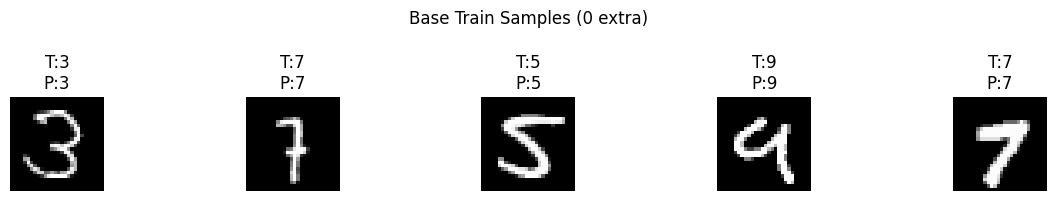

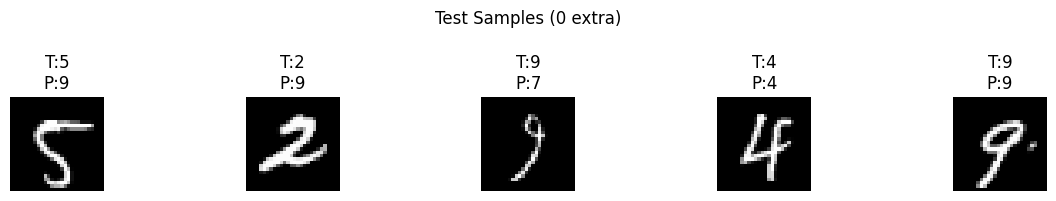

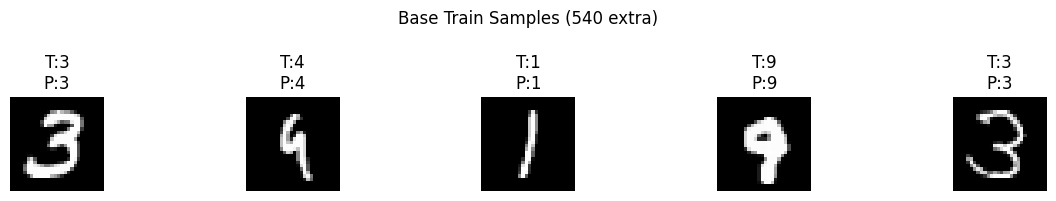

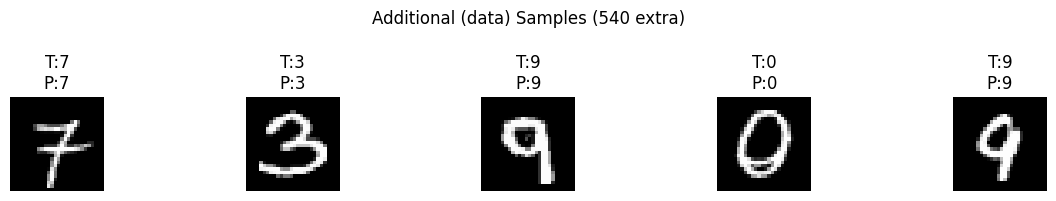

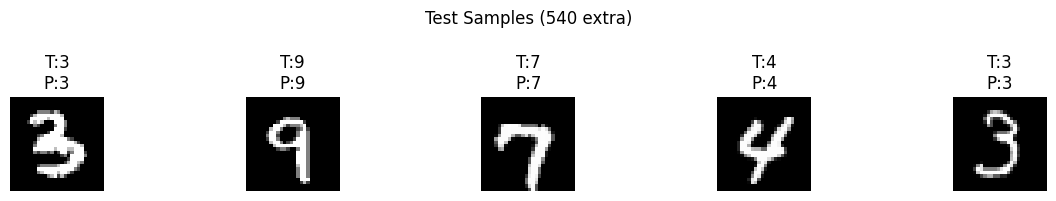

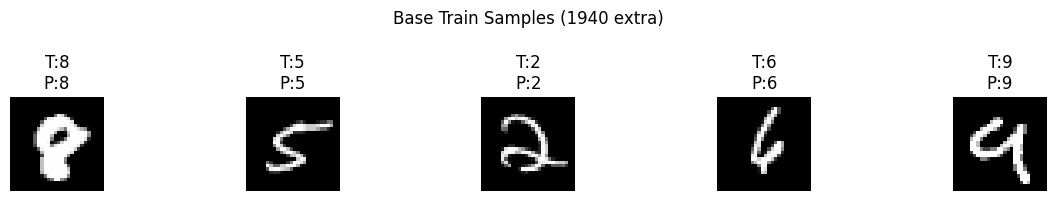

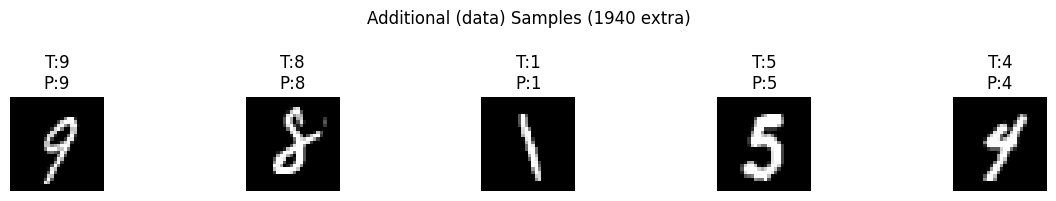

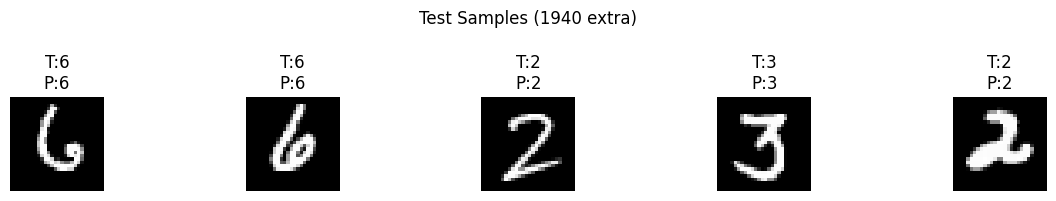

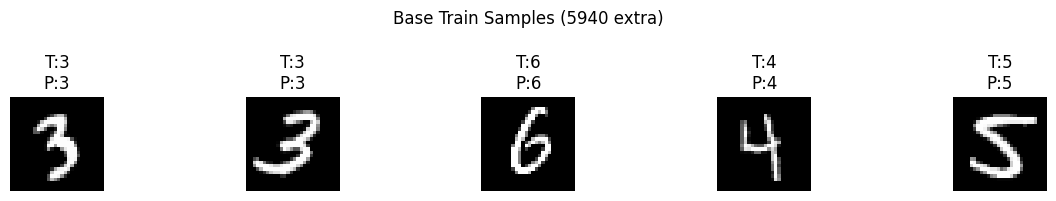

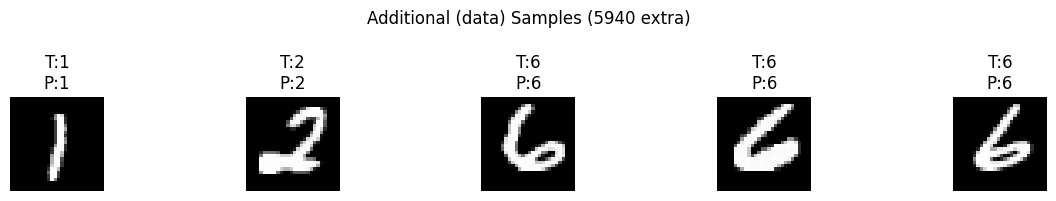

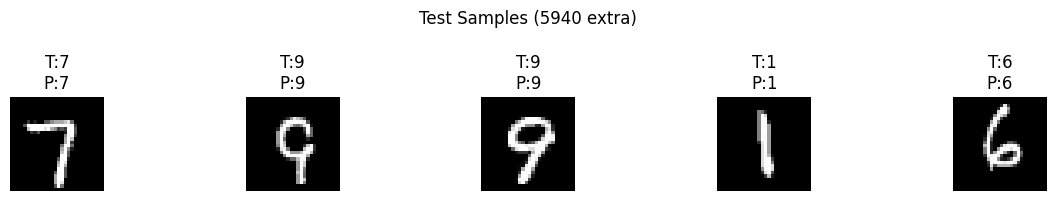

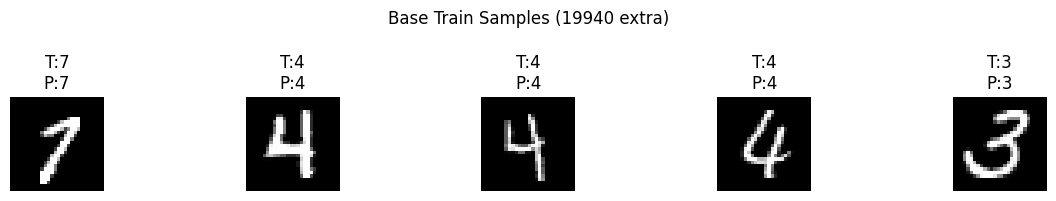

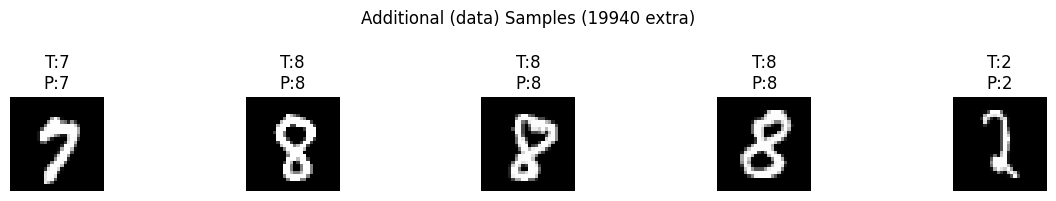

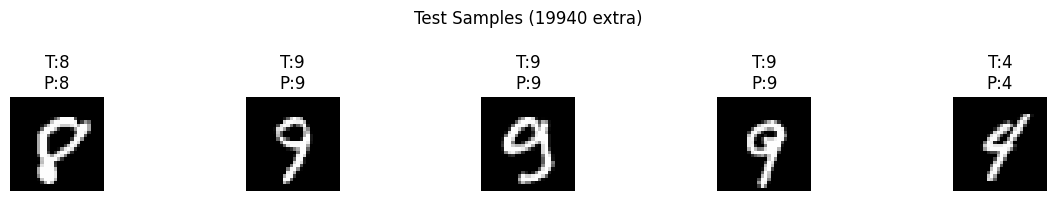

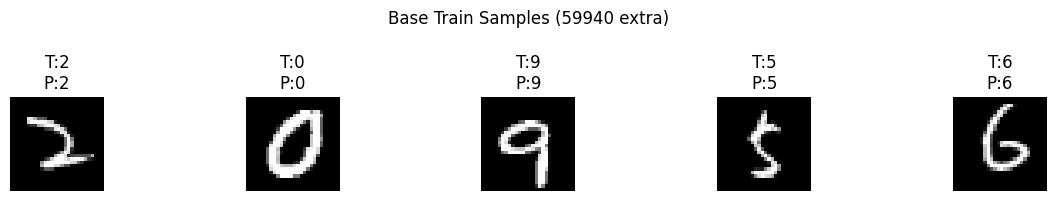

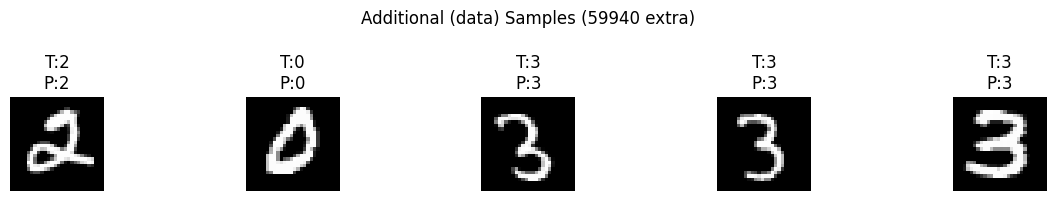

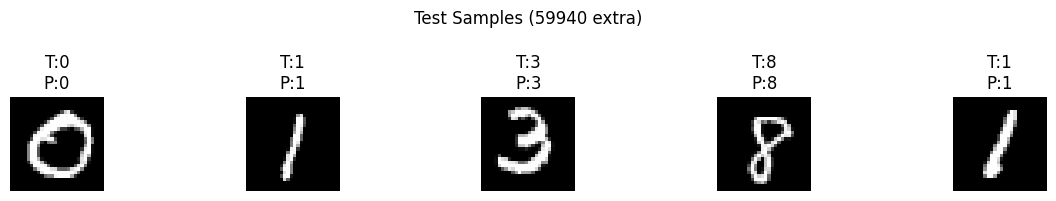

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
